# Exploring the chemical properties between medicinal and non medicinal plants

### Import modules

In [ ]:
from collections import defaultdict
import random

import pandas as pd
from tqdm import tqdm

# Cheminformatics
from rdkit.Chem.Scaffolds.MurckoScaffold import GetScaffoldForMol
from rdkit import RDLogger  

from rdkit import Chem
from rdkit.Chem import MolFromSmiles, Descriptors

# Viz
import matplotlib as mpl
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib_venn import venn2

In [ ]:
RDLogger.DisableLog('rdApp.*')

In [ ]:
%matplotlib inline

In [ ]:
random.seed(123)

In [ ]:
mpl.rcParams['figure.dpi'] = 360
sns.set_style("whitegrid")

Load plant-disease evidences

In [ ]:
plant_disease_df = pd.read_csv(
    's3://enveda-datascience/daniel_domingo/plant_disease_associations.tsv.gz',
    compression='gzip',
    sep='\t',
    usecols=[
        'plant_curie',
        'disease_curie',
    ]
)

In [ ]:
plant_disease_df.head(1)

In [ ]:
plant_disease_dict = defaultdict(set)

for plant_curie, disease_curie in tqdm(plant_disease_df.values):
    plant_disease_dict[plant_curie].add(disease_curie)

In [ ]:
medicinal_plants = set(plant_disease_df.plant_curie.unique())

In [ ]:
len(medicinal_plants)

Load plant-chemical evidences

In [ ]:
plant_chemical_df = pd.read_csv(
    's3://enveda-datascience/daniel_domingo/plant_chemical_associations.tsv.zip',
    compression='zip',
    sep='\t',
    usecols=[
        'plant_curie',
        'chemical_curie',
    ],
)

In [ ]:
plant_chemical_df.head(1)

In [ ]:
len(plant_chemical_df.chemical_curie.unique())

In [ ]:
plant_ids = set(plant_chemical_df.plant_curie.unique())

In [ ]:
len(plant_ids), len(set(plant_chemical_df.plant_curie.unique()) - medicinal_plants)

Get SMILES

In [ ]:
smiles_df = pd.read_csv(
    's3://enveda-datascience/daniel_domingo/smiles.tsv.gz',
    sep='\t',
    compression='gzip',
)

In [ ]:
smiles_df.head(1)

In [ ]:
smiles_df.shape

In [ ]:
smiles_from_pubchem_id = {}
skipped_murcko = 0
skipped_smiles = 0
skipped_wt = 0

smiles_to_property_dict = {}

for pubchem_id, smiles in tqdm(smiles_df.values):
        
    if pubchem_id.startswith('pubchem:'):
        pubchem_id = pubchem_id.replace('pubchem:', 'pubchem.compound:')
        
    """Calculate some properties"""
    try:
        molecule = MolFromSmiles(smiles)
    except:
        skipped_smiles += 1
        continue
    try:
        molecular_weight = Descriptors.ExactMolWt(molecule)
    except:
        skipped_wt += 1
        continue  

    logp = Descriptors.MolLogP(molecule)
    topological_surface_area_mapping = Chem.QED.properties(molecule).PSA
    fsp3 = Chem.Lipinski.FractionCSP3(molecule)
    
    smiles_to_property_dict[pubchem_id] = {
        'molecular_weight': molecular_weight,
        'logp': logp,
        'topological_surface_area_mapping': topological_surface_area_mapping,
        'fsp3': fsp3,
    }
    
    """Murcko scaffold"""
    try:
        murcko_smiles = GetScaffoldForMol(molecule)
    except:
        skipped_murcko += 1
        continue
        
    smiles_from_pubchem_id[pubchem_id] = murcko_smiles

In [ ]:
len(smiles_from_pubchem_id), skipped_murcko, skipped_smiles, skipped_wt

Prepare plant-chemicals dicts

In [ ]:
plant_chem_dict = defaultdict(set)
plant_scaffolds_dict = defaultdict(set)

chemicals_to_plant_dict = defaultdict(set)

for plant_curie, chemical_curie in tqdm(plant_chemical_df.values):
    
    plant_chem_dict[plant_curie].add(chemical_curie)
    chemicals_to_plant_dict[chemical_curie].add(plant_curie)
    
    if chemical_curie in smiles_from_pubchem_id:
        plant_scaffolds_dict[plant_curie].add(smiles_from_pubchem_id[chemical_curie])

### Explore distributions

We will apply a filter to avoid artifacts caused by these chemical outliers (chemicals present in a lot of plants)

In [ ]:
# Remove chemicals that are prenent in more than 100 plants

promiscuous_chemicals = [
    chemical
    for chemical, plants in chemicals_to_plant_dict.items()
    if len(plants) > 100
]

plant_chem_dict = {
    plant: {
        chemical
        for chemical in chemicals
        if chemical not in promiscuous_chemicals
    }
    for plant, chemicals in plant_chem_dict.items()
}

### Ensuring the properties of the chemicals are maintained

In [ ]:
df1 = pd.DataFrame([
    {
        "type": "Non medicinal plants",
        "molecular_weight": smiles_to_property_dict[chemical]['molecular_weight'],
        "logp": smiles_to_property_dict[chemical]['logp'],
        "fsp3": smiles_to_property_dict[chemical]['fsp3'],
        "topological_surface_area_mapping": smiles_to_property_dict[chemical]['topological_surface_area_mapping'],
    }
    for chemical in {
        chemical
        for plant, chemicals in plant_chem_dict.items()
        if plant not in medicinal_plants
        for chemical in chemicals
    }
    if chemical in smiles_to_property_dict
])

df2 = pd.DataFrame([
    {
        "type": "Medicinal plants",
        "molecular_weight": smiles_to_property_dict[chemical]['molecular_weight'],
        "logp": smiles_to_property_dict[chemical]['logp'],
        "fsp3": smiles_to_property_dict[chemical]['fsp3'],
        "topological_surface_area_mapping": smiles_to_property_dict[chemical]['topological_surface_area_mapping'],
    }
    for chemical in {
        chemical
        for plant, chemicals in plant_chem_dict.items()
        if plant in medicinal_plants
        for chemical in chemicals
    }
    if chemical in smiles_to_property_dict
])

chemical_properties_df = pd.concat([df1, df2])

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(18, 10))

fig.suptitle('Comparison of chemical properties', fontsize=34)

sns.histplot(
    ax=axes[0, 0],
    data=chemical_properties_df,
    x='molecular_weight',
    hue='type',
    kde=True,
    common_norm=False,
    stat="density",
    bins=1000,
    alpha=0.5,
    palette={
        "Medicinal plants": '#2dea99',
        'Non medicinal plants': '#f4839a',
    },
)

axes[0, 0].set(xlabel='Molecular weight')
axes[0, 0].set_xlim(0, 2000)

sns.histplot(
    ax=axes[0, 1],
    data=chemical_properties_df,
    x='logp',
    hue='type',
    kde=True,
    stat="density",
    common_norm=False,
    bins=1000,
    alpha=0.5,
    palette={
        "Medicinal plants": '#2dea99',
        'Non medicinal plants': '#f4839a',
    },
)

axes[0, 1].set(xlabel='LogP')
axes[0, 1].set_xlim(-20, 20)

sns.histplot(
    ax=axes[1, 0],
    data=chemical_properties_df,
    x='topological_surface_area_mapping',
    hue='type',
    stat="density",
    kde=True,
    common_norm=False,
    bins=1000,
    alpha=0.5,
    palette={
        "Medicinal plants": '#2dea99',
        'Non medicinal plants': '#f4839a',
    },
)

axes[1, 0].set(xlabel='Topological surface area mapping')
axes[1, 0].set_xlim(0, 750)

sns.histplot(
    ax=axes[1, 1],
    data=chemical_properties_df,
    x='fsp3',
    hue='type',
    kde=True,
    stat="density",
    common_norm=False,
    alpha=0.5,
    bins=100,
    palette={
        "Medicinal plants": '#2dea99',
        'Non medicinal plants': '#f4839a',
    },
)

axes[1, 1].set(xlabel='Fsp3')

plt.tight_layout()

plt.savefig(
    f'figure_4.png',
    dpi=400,
    bbox_inches='tight', 
)

plt.show()

In [ ]:
Exploring scaffold diversity

In [ ]:
medicinal_plants_scaffolds = set()
non_medicinal_plants_scaffolds = set()

skipped = set()
valid_scaffolds = set()

for plant_curie, chemical_curie in tqdm(plant_chemical_df.values):
    
    if chemical_curie not in smiles_from_pubchem_id:
        skipped.add(chemical_curie)
        continue

    valid_scaffolds.add(chemical_curie)

    if plant_curie in medicinal_plants:
        medicinal_plants_scaffolds.add(smiles_from_pubchem_id[chemical_curie])
    else:
        non_medicinal_plants_scaffolds.add(smiles_from_pubchem_id[chemical_curie])

In [ ]:
len(skipped), len(valid_scaffolds)

In [35]:
medicinal_plants_scaffolds = set()
non_medicinal_plants_scaffolds = set()

skipped = set()
valid_scaffolds = set()

for plant_curie, chemical_curie in tqdm(plant_chemical_df.values):
    
    if chemical_curie not in smiles_from_pubchem_id:
        skipped.add(chemical_curie)
        continue

    valid_scaffolds.add(chemical_curie)

    if plant_curie in medicinal_plants:
        medicinal_plants_scaffolds.add(smiles_from_pubchem_id[chemical_curie])
    else:
        non_medicinal_plants_scaffolds.add(smiles_from_pubchem_id[chemical_curie])

100%|██████████| 330655/330655 [00:00<00:00, 494256.20it/s]


In [36]:
len(skipped), len(valid_scaffolds)

(1225, 69954)

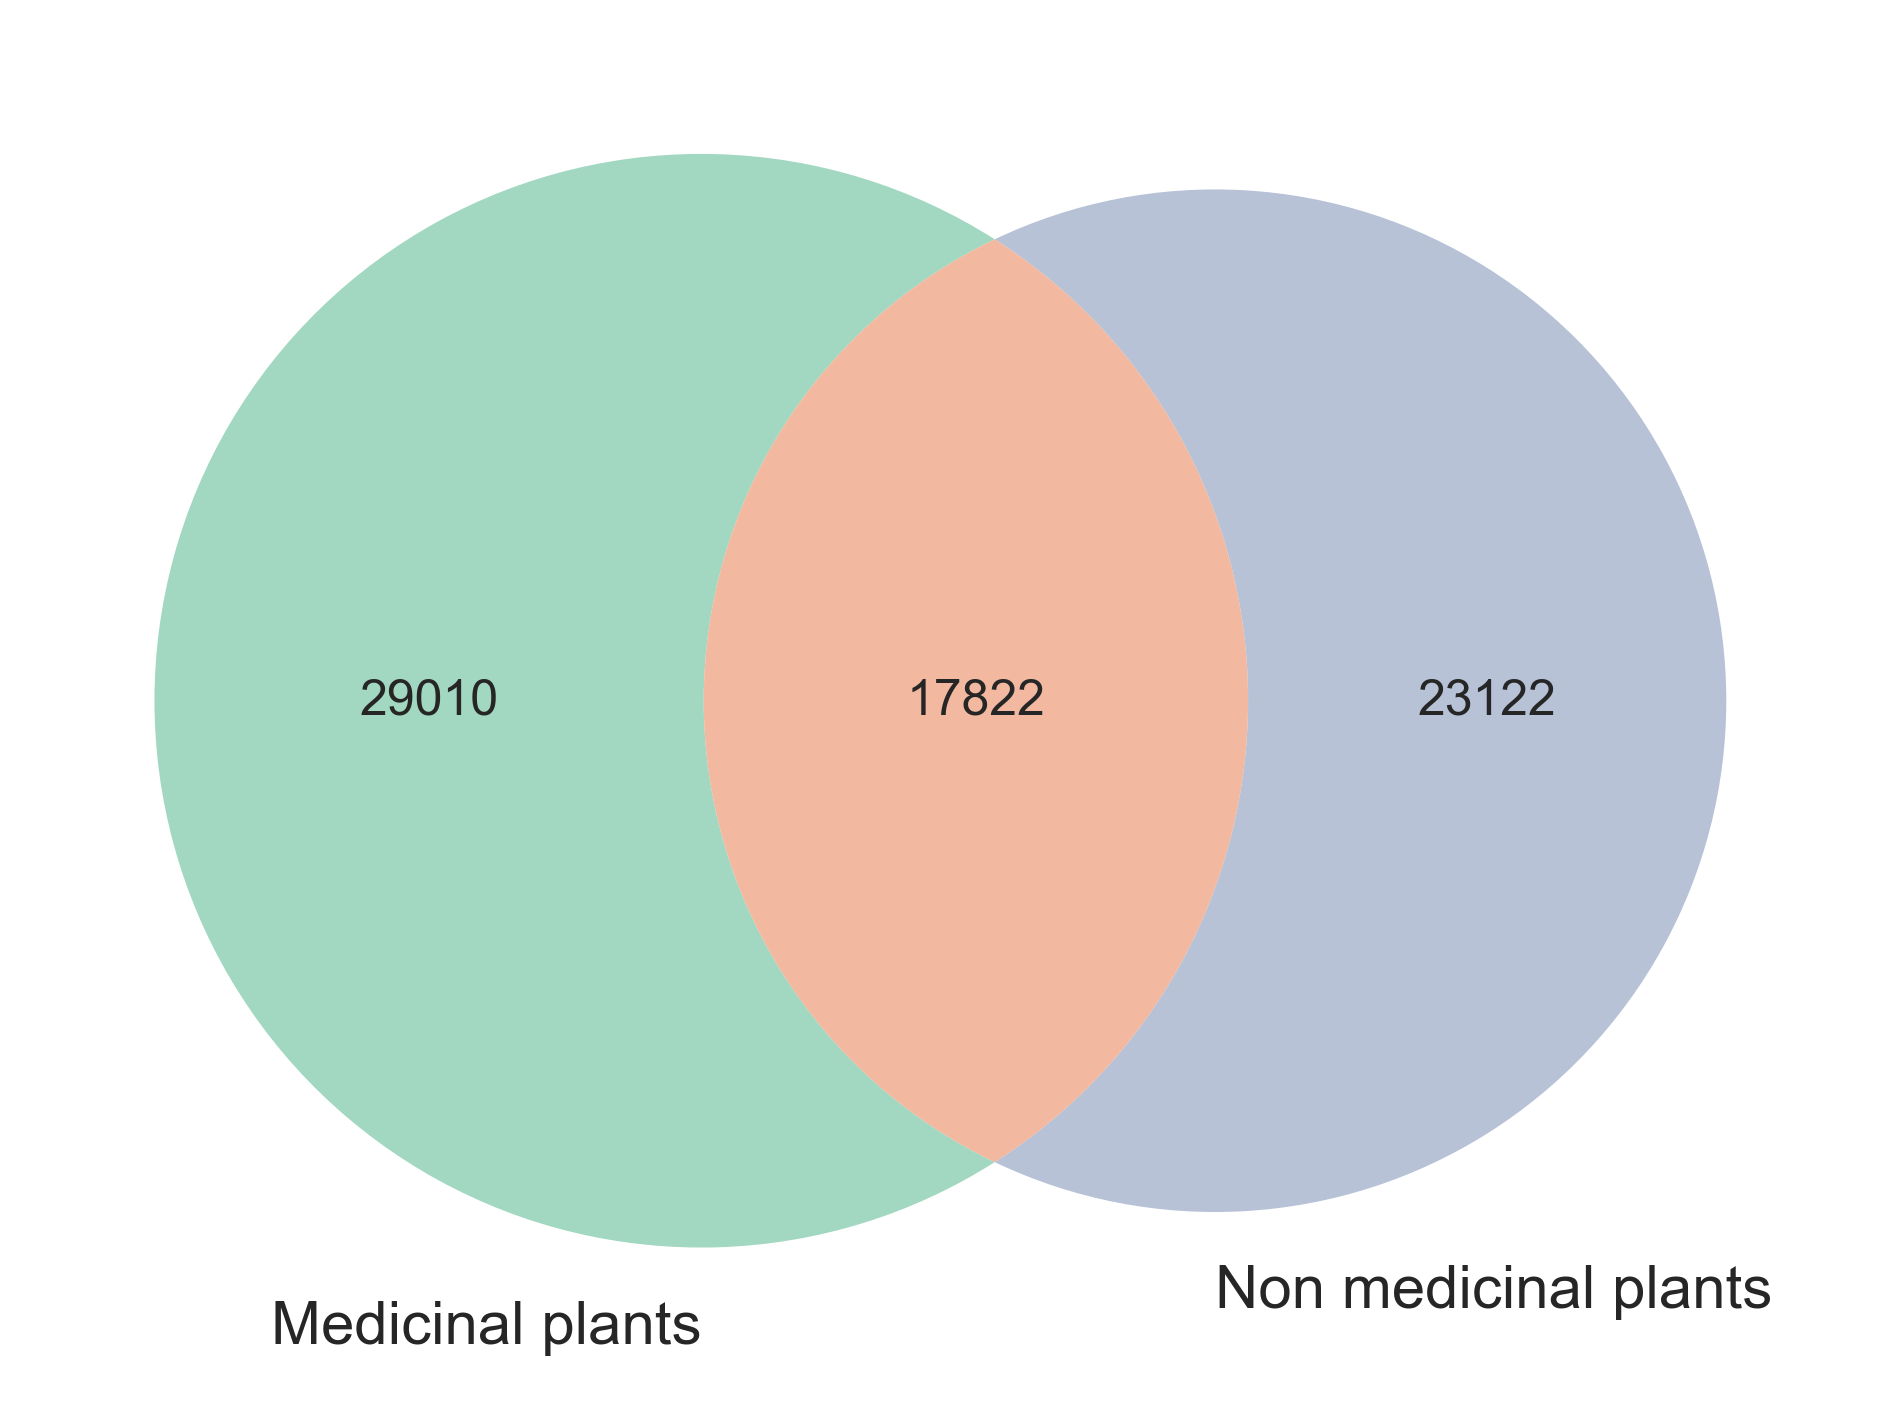

In [38]:
c3 = venn2(
    [medicinal_plants_scaffolds, non_medicinal_plants_scaffolds],
    ('Medicinal plants', 'Non medicinal plants'),
    set_colors=('#8BCEB2', '#a5b3ce'),
    alpha=.8
)
c3.get_patch_by_id('11').set_color('#efa888')
c3.get_patch_by_id('11').set_edgecolor('none')

plt.tight_layout()
plt.show()